In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')

path = './drive/MyDrive/NLP-Final/'

os.chdir(path)

Mounted at /content/drive/


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords # type: ignore
from nltk.tokenize import WordPunctTokenizer # type: ignore
from nltk.stem import WordNetLemmatizer # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from gensim.models import Word2Vec  # type: ignore

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from xgboost import XGBClassifier # type: ignore
from lightgbm import LGBMClassifier # type: ignore

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Input, Reshape # type: ignore
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding, Conv1D, GlobalMaxPooling1D # type: ignore

from transformers import BertTokenizer, TFBertForSequenceClassification # type: ignore

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve # type: ignore

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ekinc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ekinc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv(r"7allV03.csv")

In [4]:
data['category'].value_counts()

category
siyaset       700
dunya         700
ekonomi       700
kultur        700
saglik        700
spor          700
teknoloji     700
Name: count, dtype: int64

In [4]:
def preprocess_text(text):
    WPT = WordPunctTokenizer()
    stop_word_list = stopwords.words('turkish')
    lemmatizer = WordNetLemmatizer()

    pattern = r"[{}]".format(",.;:")
    text = re.sub("\d+", " ", text)
    text = re.sub(pattern, "", text)
    text = text.lower()

    tokens = WPT.tokenize(text)

    filtered_tokens = [token for token in tokens if token not in stop_word_list]

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return " ".join(lemmatized_tokens)

data['cleaned_text'] = data['text'].apply(preprocess_text)

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['category'])

X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

In [24]:
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train).astype(np.float32)
X_test_bow = vectorizer_bow.transform(X_test).astype(np.float32)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

w2v_model = Word2Vec(sentences=X_train.apply(str.split), vector_size=100, window=5, min_count=1)

X_train_w2v = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(100)], axis=0) for sentence in X_train])
X_test_w2v = np.array([np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(100)], axis=0) for sentence in X_test])

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    accuracy = report["accuracy"]
    precision = {cls: metrics["precision"] for cls, metrics in report.items() if cls not in ["accuracy", "macro avg", "weighted avg"]}
    recall = {cls: metrics["recall"] for cls, metrics in report.items() if cls not in ["accuracy", "macro avg", "weighted avg"]}
    f1_score = {cls: metrics["f1-score"] for cls, metrics in report.items() if cls not in ["accuracy", "macro avg", "weighted avg"]}

    print(f"Accuracy: {accuracy:.4f}")
    for cls in precision.keys():
        print(f"Class {cls} - Precision: {precision[cls]:.4f}, Recall: {recall[cls]:.4f}, F1-Score: {f1_score[cls]:.4f}")

    y_test_bin = np.eye(len(np.unique(y_test)))[y_test]
    auc_score = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
    print(f"AUC (One-vs-Rest): {auc_score:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    for i, cls in enumerate(np.unique(y_test)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 100
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697
Random Forest Results
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.49      0.45       131
           1       0.44      0.44      0.44       142
           2       0.57      0.55      0.56       139
           3       0.40      0.48      0.44       122
           4    

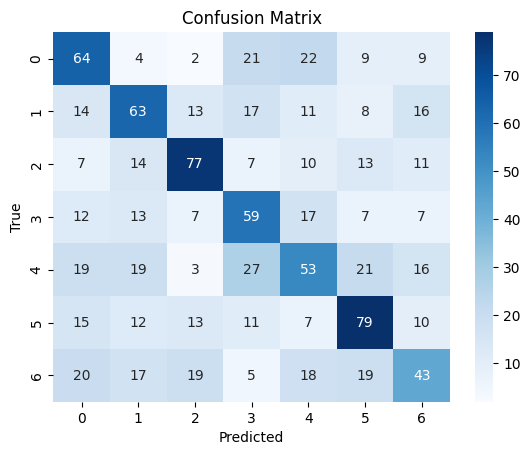

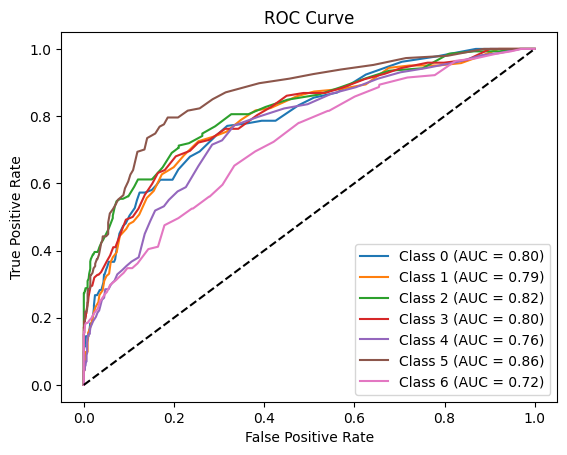

XGBoost Results
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       131
           1       0.46      0.45      0.45       142
           2       0.60      0.55      0.57       139
           3       0.45      0.52      0.48       122
           4       0.43      0.43      0.43       158
           5       0.57      0.58      0.57       147
           6       0.40      0.35      0.38       141

    accuracy                           0.47       980
   macro avg       0.48      0.48      0.47       980
weighted avg       0.48      0.47      0.47       980

Accuracy: 0.4745
Class 0 - Precision: 0.4173, Recall: 0.4427, F1-Score: 0.4296
Class 1 - Precision: 0.4571, Recall: 0.4507, F1-Score: 0.4539
Class 2 - Precision: 0.6032, Recall: 0.5468, F1-Score: 0.5736
Class 3 - Precision: 0.4507, Recall: 0.5246, F1-Score: 0.4848
Class 4 - Precision: 0.4304, Recall: 0.4304, F1-Score: 0.4304
Class 5 - Precision: 0.5667, Recall: 

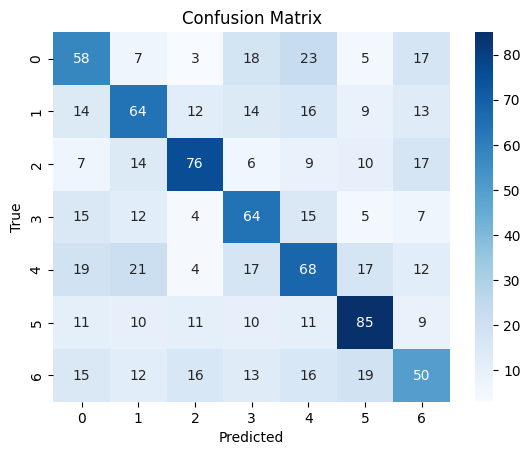

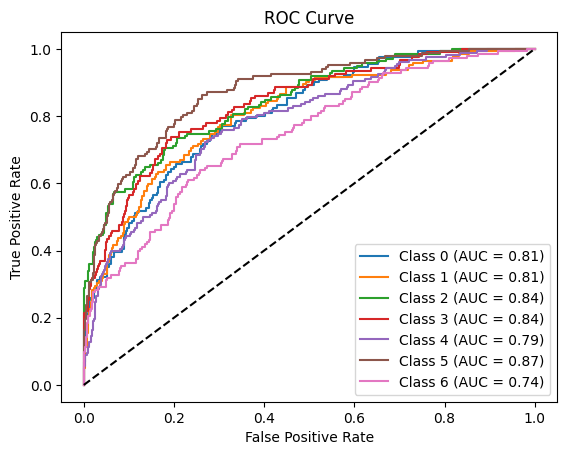

LightGBM Results
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       131
           1       0.46      0.51      0.49       142
           2       0.57      0.53      0.55       139
           3       0.48      0.52      0.50       122
           4       0.46      0.47      0.47       158
           5       0.59      0.56      0.58       147
           6       0.40      0.35      0.38       141

    accuracy                           0.49       980
   macro avg       0.49      0.49      0.49       980
weighted avg       0.49      0.49      0.49       980

Accuracy: 0.4878
Class 0 - Precision: 0.4485, Recall: 0.4656, F1-Score: 0.4569
Class 1 - Precision: 0.4650, Recall: 0.5141, F1-Score: 0.4883
Class 2 - Precision: 0.5692, Recall: 0.5324, F1-Score: 0.5502
Class 3 - Precision: 0.4809, Recall: 0.5164, F1-Score: 0.4980
Class 4 - Precision: 0.4625, Recall: 0.4684, F1-Score: 0.4654
Class 5 - Precision: 0.5887, Recall:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


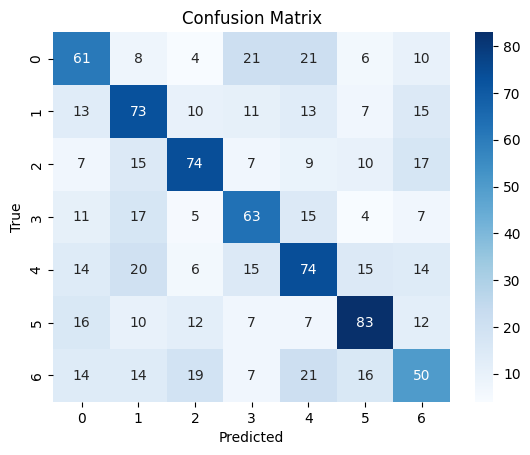

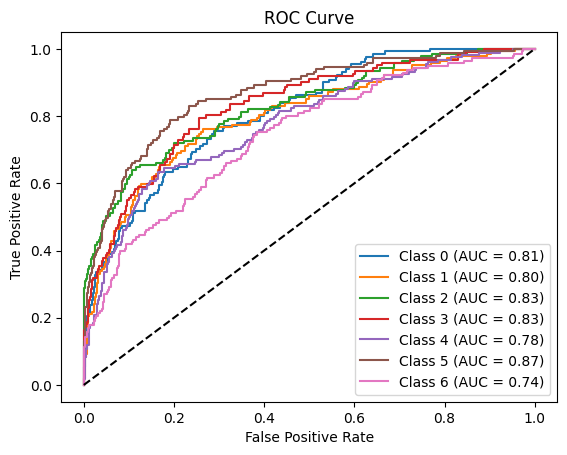

In [26]:
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()

rf_model.fit(X_train_w2v, y_train)
xgb_model.fit(X_train_w2v, y_train)
lgbm_model.fit(X_train_w2v, y_train)

print("Random Forest Results")
evaluate_model(rf_model, X_test_w2v, y_test)

print("XGBoost Results")
evaluate_model(xgb_model, X_test_w2v, y_test)

print("LightGBM Results")
evaluate_model(lgbm_model, X_test_w2v, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20998
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 4938
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697
Random Forest Results
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       131
           1       0.85      0.78      0.81       142
           2       0.87      0.90      0.88       139
     

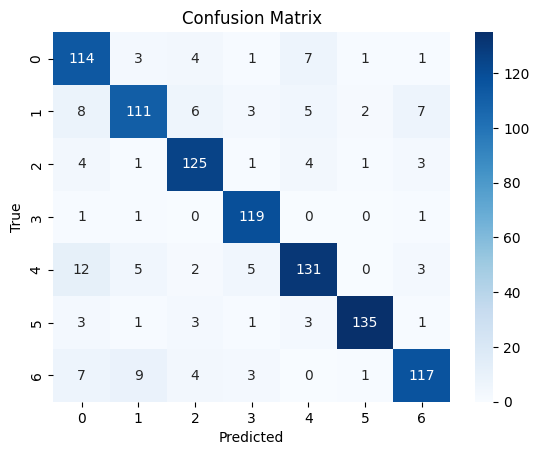

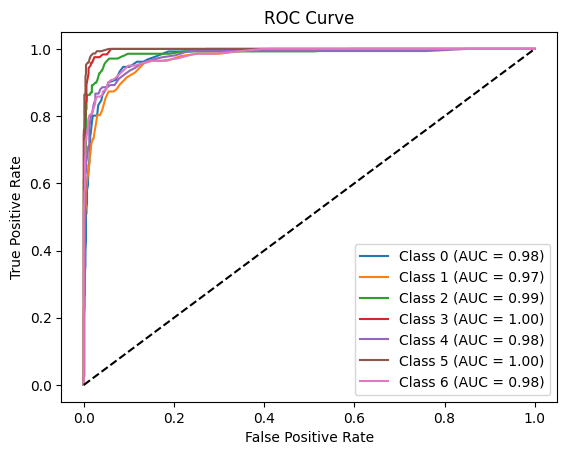

XGBoost Results
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       131
           1       0.77      0.80      0.78       142
           2       0.86      0.89      0.87       139
           3       0.88      0.93      0.90       122
           4       0.89      0.80      0.84       158
           5       0.96      0.93      0.94       147
           6       0.85      0.84      0.85       141

    accuracy                           0.86       980
   macro avg       0.86      0.86      0.86       980
weighted avg       0.86      0.86      0.86       980

Accuracy: 0.8551
Class 0 - Precision: 0.7836, Recall: 0.8015, F1-Score: 0.7925
Class 1 - Precision: 0.7687, Recall: 0.7958, F1-Score: 0.7820
Class 2 - Precision: 0.8552, Recall: 0.8921, F1-Score: 0.8732
Class 3 - Precision: 0.8769, Recall: 0.9344, F1-Score: 0.9048
Class 4 - Precision: 0.8881, Recall: 0.8038, F1-Score: 0.8439
Class 5 - Precision: 0.9645, Recall: 

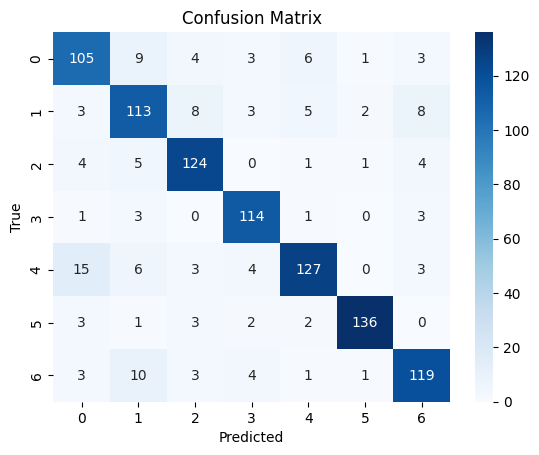

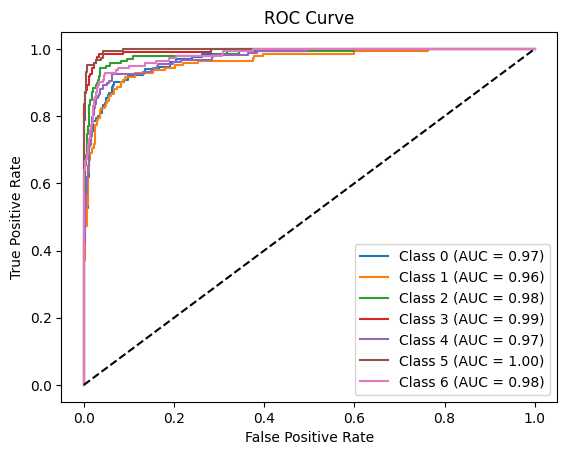

LightGBM Results
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       131
           1       0.81      0.85      0.82       142
           2       0.87      0.93      0.90       139
           3       0.91      0.96      0.93       122
           4       0.92      0.82      0.87       158
           5       0.97      0.92      0.94       147
           6       0.88      0.87      0.87       141

    accuracy                           0.88       980
   macro avg       0.88      0.88      0.88       980
weighted avg       0.88      0.88      0.88       980

Accuracy: 0.8816
Class 0 - Precision: 0.8284, Recall: 0.8473, F1-Score: 0.8377
Class 1 - Precision: 0.8054, Recall: 0.8451, F1-Score: 0.8247
Class 2 - Precision: 0.8658, Recall: 0.9281, F1-Score: 0.8958
Class 3 - Precision: 0.9070, Recall: 0.9590, F1-Score: 0.9323
Class 4 - Precision: 0.9220, Recall: 0.8228, F1-Score: 0.8696
Class 5 - Precision: 0.9712, Recall:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


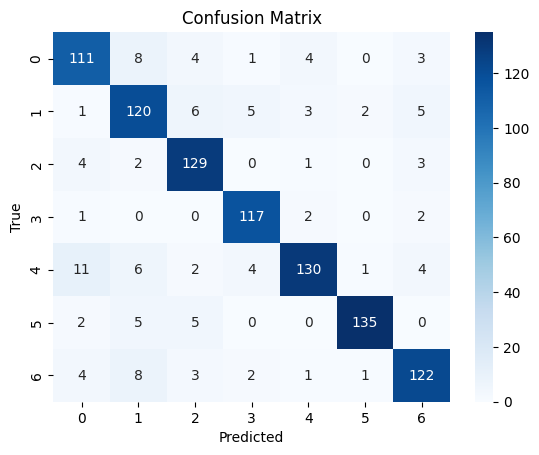

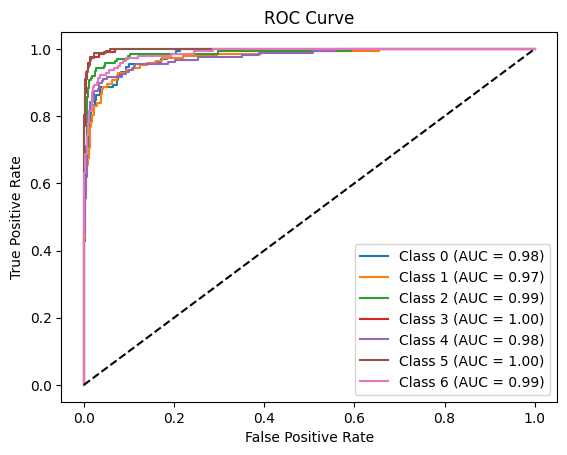

In [25]:
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()

rf_model.fit(X_train_bow, y_train)
xgb_model.fit(X_train_bow, y_train)
lgbm_model.fit(X_train_bow, y_train)

print("Random Forest Results")
evaluate_model(rf_model, X_test_bow, y_test)

print("XGBoost Results")
evaluate_model(xgb_model, X_test_bow, y_test)

print("LightGBM Results")
evaluate_model(lgbm_model, X_test_bow, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124842
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 4938
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697
Random Forest Results
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       131
           1       0.84      0.77      0.80       142
           2       0.86      0.92      0.89       139
           3       0.86      0.94      0.90       122
           4  

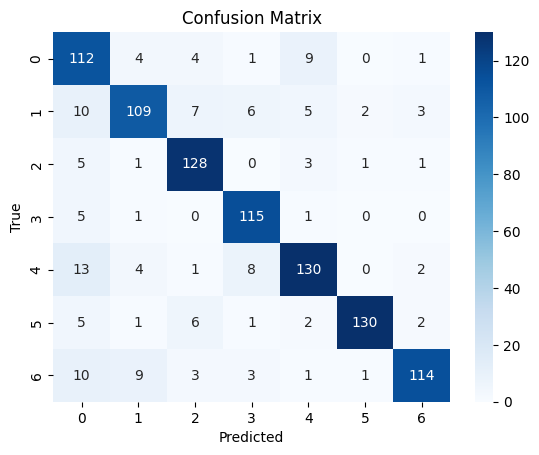

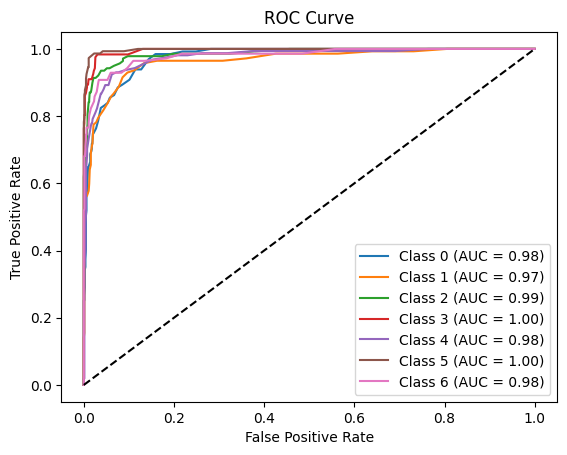

XGBoost Results
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       131
           1       0.83      0.78      0.81       142
           2       0.86      0.91      0.88       139
           3       0.91      0.95      0.93       122
           4       0.87      0.81      0.84       158
           5       0.96      0.92      0.94       147
           6       0.86      0.84      0.85       141

    accuracy                           0.86       980
   macro avg       0.86      0.86      0.86       980
weighted avg       0.86      0.86      0.86       980

Accuracy: 0.8602
Class 0 - Precision: 0.7415, Recall: 0.8321, F1-Score: 0.7842
Class 1 - Precision: 0.8346, Recall: 0.7817, F1-Score: 0.8073
Class 2 - Precision: 0.8571, Recall: 0.9065, F1-Score: 0.8811
Class 3 - Precision: 0.9062, Recall: 0.9508, F1-Score: 0.9280
Class 4 - Precision: 0.8707, Recall: 0.8101, F1-Score: 0.8393
Class 5 - Precision: 0.9574, Recall: 

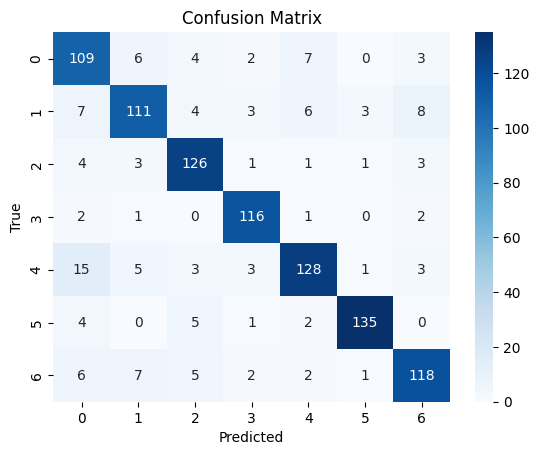

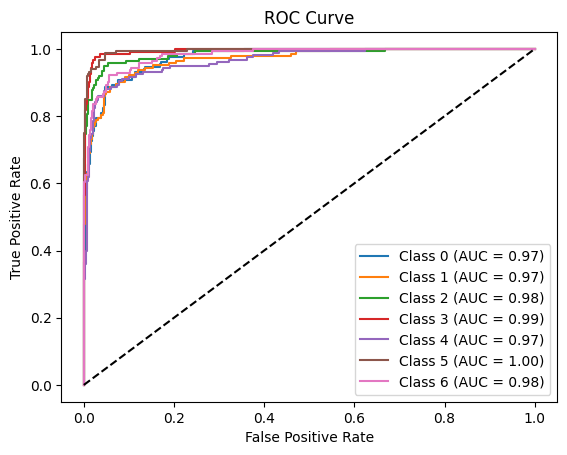

LightGBM Results
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       131
           1       0.85      0.82      0.84       142
           2       0.86      0.92      0.89       139
           3       0.91      0.97      0.94       122
           4       0.90      0.84      0.87       158
           5       0.97      0.92      0.94       147
           6       0.89      0.88      0.88       141

    accuracy                           0.88       980
   macro avg       0.88      0.88      0.88       980
weighted avg       0.88      0.88      0.88       980

Accuracy: 0.8816
Class 0 - Precision: 0.7971, Recall: 0.8397, F1-Score: 0.8178
Class 1 - Precision: 0.8478, Recall: 0.8239, F1-Score: 0.8357
Class 2 - Precision: 0.8591, Recall: 0.9209, F1-Score: 0.8889
Class 3 - Precision: 0.9077, Recall: 0.9672, F1-Score: 0.9365
Class 4 - Precision: 0.9041, Recall: 0.8354, F1-Score: 0.8684
Class 5 - Precision: 0.9712, Recall:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


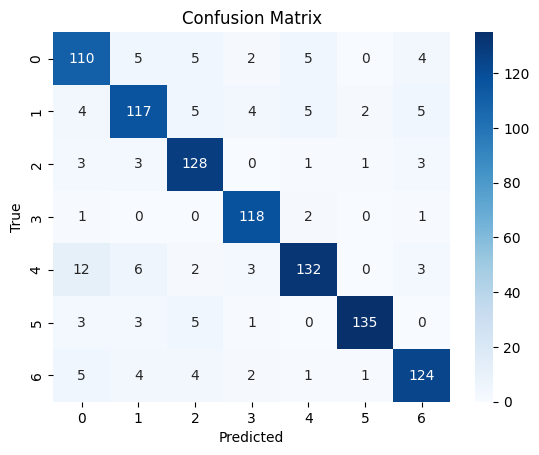

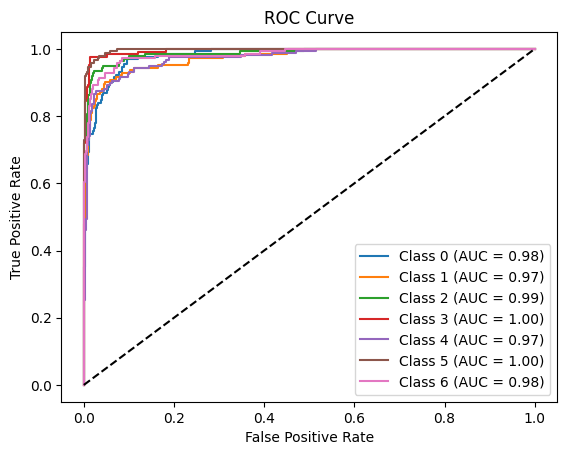

In [6]:
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()

rf_model.fit(X_train_tfidf, y_train)
xgb_model.fit(X_train_tfidf, y_train)
lgbm_model.fit(X_train_tfidf, y_train)

print("Random Forest Results")
evaluate_model(rf_model, X_test_tfidf, y_test)

print("XGBoost Results")
evaluate_model(xgb_model, X_test_tfidf, y_test)

print("LightGBM Results")
evaluate_model(lgbm_model, X_test_tfidf, y_test)

In [ ]:
def evaluate_model_ann(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")

    try:
        y_test_bin = np.eye(len(label_encoder.classes_))[y_test]
        auc_score = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr')
        print(f"AUC (One-vs-Rest): {auc_score:.4f}")

        for i in range(len(label_encoder.classes_)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_pred_probs[:, i]):.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='best')
        plt.show()
    except ValueError as e:
        print(f"ROC-AUC computation failed: {e}")

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1610 - loss: 1.9699 - val_accuracy: 0.1671 - val_loss: 1.9443
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1402 - loss: 1.9532 - val_accuracy: 0.1365 - val_loss: 1.9478
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1551 - loss: 1.9511 - val_accuracy: 0.1467 - val_loss: 1.9442
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1360 - loss: 1.9481 - val_accuracy: 0.1429 - val_loss: 1.9446
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1277 - loss: 1.9488 - val_accuracy: 0.1633 - val_loss: 1.9471
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1575 - loss: 1.9474 - val_accuracy: 0.1441 - val_loss: 1.9457
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1384 - loss: 1.9469 - val_accuracy: 0.1620 - val_loss: 1.9462
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1518 - loss: 1.9448 - val_accuracy: 0.1365 - val_loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


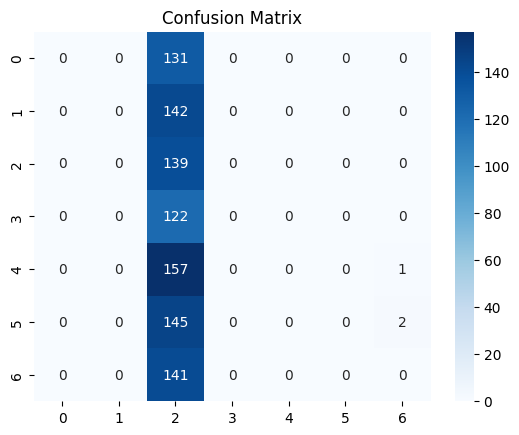

Accuracy: 0.1418
AUC (One-vs-Rest): 0.5457


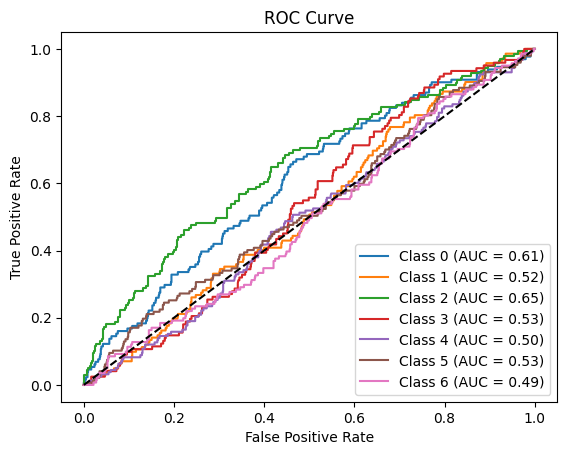

In [31]:
ann_model = Sequential([
    Input(shape=(X_train_w2v.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

print("Evaluation for ANN")
evaluate_model_ann(ann_model, X_test_w2v, y_test)

Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6214 - loss: 1.2540 - val_accuracy: 0.8878 - val_loss: 0.4691
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9836 - loss: 0.0892 - val_accuracy: 0.8967 - val_loss: 0.5243
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9986 - loss: 0.0182 - val_accuracy: 0.8916 - val_loss: 0.5624
Evaluation for ANN
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       131
           1       0.89      0.85      0.87       142
           2       0.91      0.95      0.93       139
           3       0.92      0.98      0.95       122
           4       0.90      0.91      0.90       158
           5       0.99      0.97      0.98       147
           6       0.92      0.86      0.89       141

    accuracy                           0.91       980
   macro avg       0.91      0.92      0.91       980
weighted avg       0

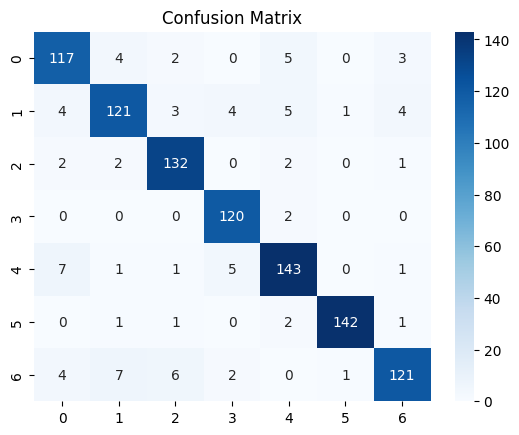

Accuracy: 0.9143
AUC (One-vs-Rest): 0.9863


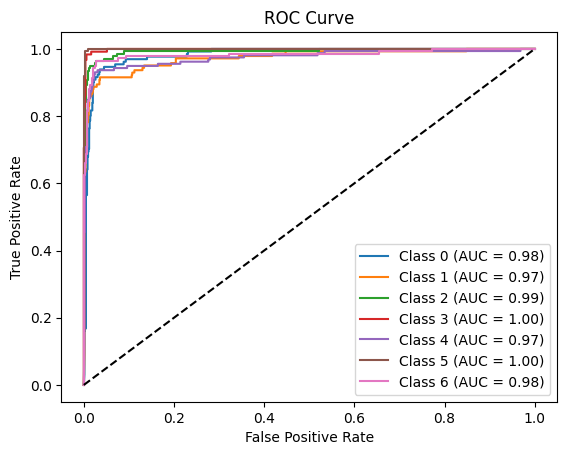

In [28]:
ann_model = Sequential([
    Input(shape=(X_train_bow.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_bow, y_train, epochs=3, batch_size=32, validation_split=0.2)

print("Evaluation for ANN")
evaluate_model_ann(ann_model, X_test_bow, y_test)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.4676 - loss: 1.7818 - val_accuracy: 0.8776 - val_loss: 0.6665
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9748 - loss: 0.2782 - val_accuracy: 0.8916 - val_loss: 0.3695
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9969 - loss: 0.0305 - val_accuracy: 0.8929 - val_loss: 0.3532
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9997 - loss: 0.0123 - val_accuracy: 0.8929 - val_loss: 0.3563
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9991 - loss: 0.0095 - val_accuracy: 0.8903 - val_loss: 0.3525
Evaluation for ANN
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       131
           1       0.89      0.89      0.89       142
           2       0.93      0.94      0.94       139
           3       0.94      0.97      0.96       122
           4       0.91      0.89     

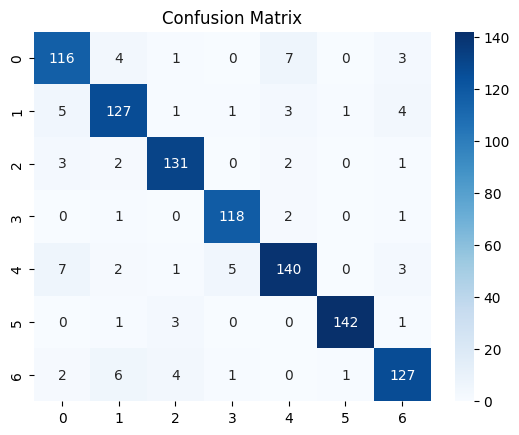

Accuracy: 0.9194
AUC (One-vs-Rest): 0.9912


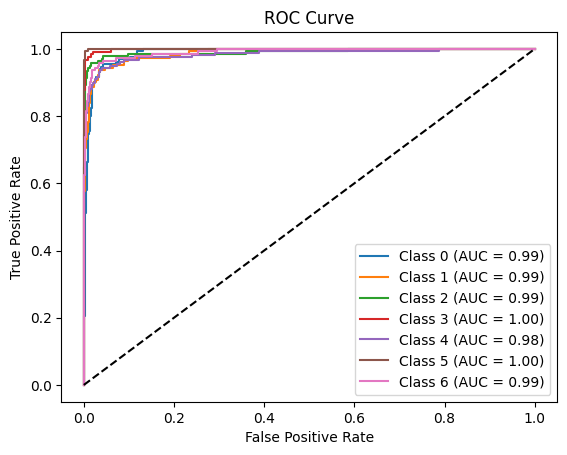

In [7]:
ann_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2)

print("Evaluation for ANN")
evaluate_model_ann(ann_model, X_test_tfidf, y_test)

In [ ]:
def evaluate_model_cnn_lstm(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")

    y_test_bin = np.eye(len(label_encoder.classes_))[y_test]
    auc_score = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr')
    print(f"AUC (One-vs-Rest): {auc_score:.4f}")

    for i in range(len(label_encoder.classes_)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_pred_probs[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1847 - loss: 1.8994 - val_accuracy: 0.2615 - val_loss: 1.6878
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2684 - loss: 1.7027 - val_accuracy: 0.3202 - val_loss: 1.6092
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3694 - loss: 1.4694 - val_accuracy: 0.3431 - val_loss: 1.6386
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3648 - loss: 1.4713 - val_accuracy: 0.3163 - val_loss: 1.6997
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3924 - loss: 1.3946 - val_accuracy: 0.3941 - val_loss: 1.4797
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5012 - loss: 1.1920 - val_accuracy: 0.3801 - val_loss: 1.4681
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5740 - loss: 0.9716 - val_accuracy: 0.4911 - val_loss: 1.3372
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6783 - loss: 0.7511 - val_accuracy: 0.5536 - val_loss: 1.

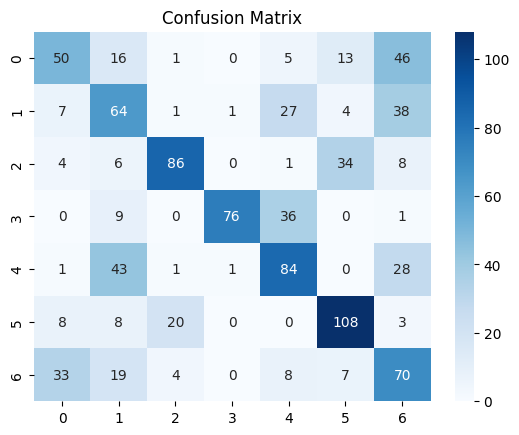

Accuracy: 0.5490
AUC (One-vs-Rest): 0.8769


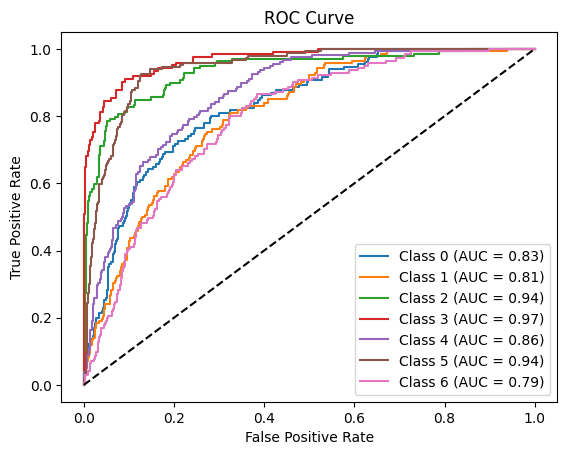

In [21]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = 20000
embedding_dim = 100

cnn_lstm_model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Conv1D(128, 5, activation='relu'),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dropout(0.1),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2)

evaluate_model_cnn_lstm(cnn_lstm_model, X_test_seq, y_test)

In [ ]:
def evaluate_model_bert(model, X_test, y_test):
    y_pred_probs = model.predict(dict(X_test))
    y_pred = np.argmax(y_pred_probs.logits, axis=1)

    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")

    y_test_bin = np.eye(len(label_encoder.classes_))[y_test]
    auc_score = roc_auc_score(y_test_bin, y_pred_probs.logits, multi_class='ovr')
    print(f"AUC (One-vs-Rest): {auc_score:.4f}")

    for i in range(len(label_encoder.classes_)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs.logits[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_pred_probs.logits[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/10
392/392 [==============================] - 85s 143ms/step - loss: 7.3027 - accuracy: 0.1629 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 2/10
392/392 [==============================] - 51s 129ms/step - loss: 7.2316 - accuracy: 0.1425 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 3/10
392/392 [==============================] - 48s 124ms/step - loss: 7.1082 - accuracy: 0.1425 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 4/10
392/392 [==============================] - 48s 121ms/step - loss: 7.0876 - accuracy: 0.1425 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 5/10
392/392 [==============================] - 47s 119ms/step - loss: 7.1853 - accuracy: 0.1425 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 6/10
392/392 [==============================] - 47s 119ms/step - loss: 7.1133 - accuracy: 0.1425 - val_loss: 7.1750 - val_accuracy: 0.1671
Epoch 7/10
392/392 [==============================] - 46s 118ms/step - loss: 7.2573 - accuracy: 0.1425 - val_loss: 7.1750 - val_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


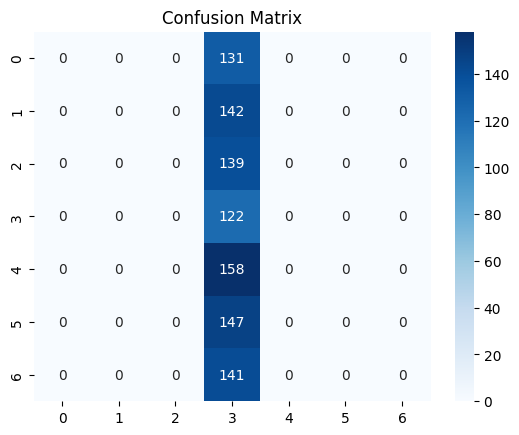

Accuracy: 0.1245
AUC (One-vs-Rest): 0.5096


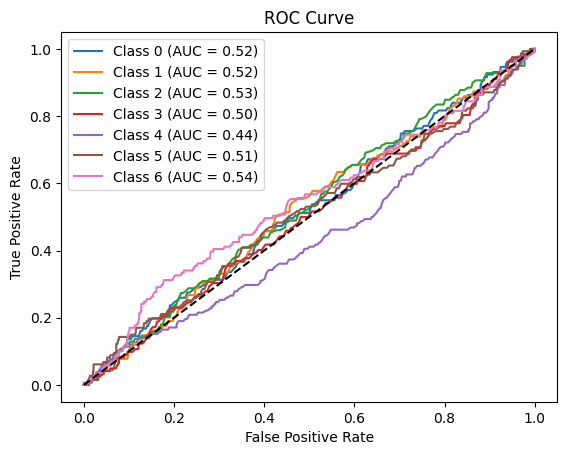

In [22]:
tokenizer = BertTokenizer.from_pretrained('savasy/bert-turkish-text-classification')
bert_model = TFBertForSequenceClassification.from_pretrained('savasy/bert-turkish-text-classification', num_labels=len(label_encoder.classes_))

def tokenize_inputs(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="tf")

X_train_bert = tokenize_inputs(X_train)
X_test_bert = tokenize_inputs(X_test)

y_train_cat = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_cat = to_categorical(y_test, num_classes=len(label_encoder.classes_))

bert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bert_model.fit(
    dict(X_train_bert), y_train_cat, validation_split=0.2, epochs=10, batch_size=8
)

print("Evaluation for BERT")
evaluate_model_bert(bert_model, X_test_bert, y_test)